In [166]:
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [167]:
# Matplotlib figure size to have large enough image plotting
#FIGURE_SIZE = (12, 6)
FIGURE_SIZE = (12, 18)

def plot_bgr(img):
    """ A helper for plotting a BGR image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_gray(gray):
    """ A helper for plotting a grayscale image with matplotlib """
    plt.figure(figsize=FIGURE_SIZE)
    plt.imshow(gray, cmap='gray')

In [224]:
IMG_PATH = "/home/rattus/Free/Udacity/CarND-Capstone/imgs/traffic/wild"
images = os.listdir(IMG_PATH)
images.sort()

In [225]:
SAT_THR = 160
VAL_THR = 200

In [226]:
def clamp_saturation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sat = hsv[:,:,1]
    val = hsv[:,:,2]
    mask = np.zeros(sat.shape)
    mask[sat > SAT_THR] += 50
    mask[val > VAL_THR] += 50
    mask[mask < 100] = 0
    mask[mask >= 100] = 1
    return mask.astype(np.uint8)

In [227]:
def detect_state(masked_light):
    red_mean = masked_light[:,:,2].mean()
    green_mean = masked_light[:,:,1].mean()
    blue_mean = masked_light[:,:,0].mean()
    
    red_green_diff_ratio = (red_mean + green_mean) / (abs(red_mean - green_mean)*2. + 0.01)
    non_blue_ratio = max(0., (red_mean + green_mean) - (2. * blue_mean))
    #print("r-g, nonbl ", red_green_diff_ratio, non_blue_ratio)
    yellow_mean = red_green_diff_ratio * non_blue_ratio
    # States: 0 - red, 1 - yellow, 2 - green, 4 - Unknown
    #print("R, G, B, Y : {:0.2f}, {:0.2f}, {:0.2f}, {:0.2f}"
    #      .format(red_mean, green_mean, blue_mean, yellow_mean))
    indices = np.array([red_mean, yellow_mean, green_mean])
    if (indices.max() < 0.15 or indices.max() < blue_mean):
        return 4
    return indices.argmax()

In [228]:
def draw_state(image, state):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    states = ["Red", "Yellow", "Green", "Unknown", "Unknown"]
    state_str = states[state]

    org = (5, image.shape[0] - 5) 
    fontScale = 0.7
    color = (250, 250, 250) 
    thickness = 1

    result = cv2.putText(image, state_str, org, font,
                   fontScale, color, thickness, cv2.LINE_AA) 
    return result

True

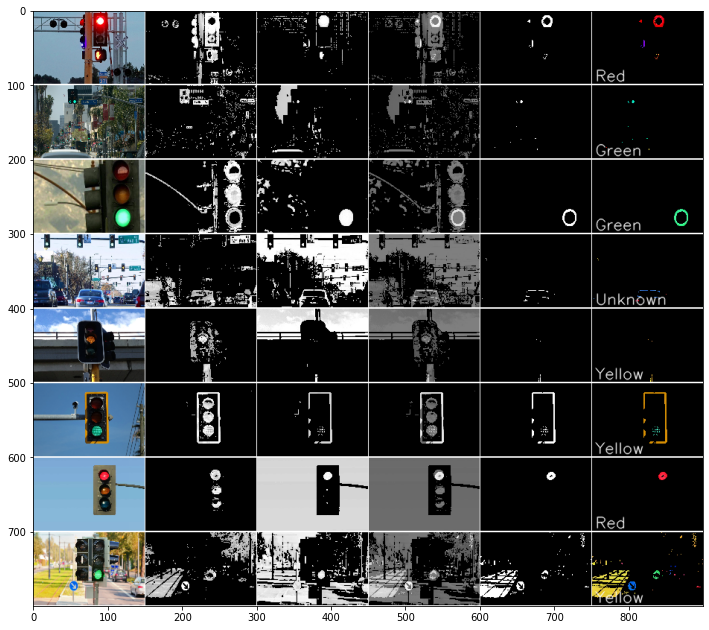

In [232]:
idx = 13
illustrations = []
for i in range(len(images)):
#for i in range(idx, idx+1):
    img = cv2.resize(cv2.imread(os.path.join(IMG_PATH, images[i])), (150,100))
    
    mask = clamp_saturation(img)
    
    lights_only = np.zeros(img.shape)
    lights_only = cv2.bitwise_and(img, img, mask=mask)
    state = detect_state(lights_only)

    # Illustration generation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    sat = hsv[:,:,1]
    val = hsv[:,:,2]
    sat[sat < SAT_THR] = 0
    val[val < VAL_THR] = 0
    sat_val_sum = (sat//2)+(val//2)
    mask_gray = mask * 255
    # Vertical white border lines
    lights_only[:,0,:] = 255
    mask[:,0] = 255
    sat[:,0] = 255
    val[:,0] = 255
    sat_val_sum[:,0] = 255
    mask_gray[:,0] = 255
    
    gray_parts = np.expand_dims(
                    np.concatenate(
                        (sat, val, sat_val_sum, mask_gray), axis=1),
                 2)
    gray_parts_as_bgr = np.concatenate((gray_parts,gray_parts,gray_parts), axis=2)
    all_stripe = np.concatenate(
        (img, gray_parts_as_bgr, draw_state(lights_only, state)),
        axis=1)
    # Horizontal white border lines
    all_stripe[0,:,:] = 255
    all_stripe[-1,:,:] = 255
    illustrations.append(all_stripe)

illustrations = np.concatenate(np.array(illustrations), axis = 0)
plot_bgr(illustrations)
cv2.imwrite("illustrations.jpg", illustrations)

# CarND-Controls-PID Writeup
Self-Driving Car Engineer Nanodegree Program
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


[architecture]: ./imgs/final-project-ros-graph-v2.png "Vehicle control system ROS nodes"

## Overview

This System Integration project implements a software suite that could drive an autonomous vehicle in the [simulator](https://github.com/udacity/self-driving-car-sim/releases) or in real world with some limitations (e.g. in a controlled safe environment).

The system is based on the robotic operational system [ROS](https://www.ros.org/) and contains an ensemble of ROS nodes, performing various tasks for controlling the vehicle:

![][architecture]














System overview

Nodes:
* waypoint loader
* waypoint updater
* traffic light detector
* bridge/server/cppbridge
* dbw_node with its twist controller

Describe node interaction using a picture(s)

My approach to:
* tl_detector
* dbw node and twist contr
    twist brake force computing - throttle wiggle avoidance
    lowpass filter for Yaw
* wpt updater
    why less wpts
    frequency adjustment

Detection (optional)
* dataset gathering
    from sim
        photos, samples
* image preprocessing (top part, colorization)
    camera is watching the sky and never the road, thus it's ok
* model architecture
    opencv classifier, no models
    describe the pictures (with illustrations of various techniques)
    * any chance to make a real road photo?
        yes, the demo illustration now available
    
    Video link:
    https://youtu.be/qA7bLBL-geI


Rubric points:
* The code is built successfully and connects to the simulator.
* Waypoints are published to plan Carla’s route around the track.
* Controller commands are published to operate Carla’s throttle, brake, and steering.
* Successfully navigate the full track more than once.

Video? (....)
